In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

from scripts.forecast_plot import forecast_plot

from prophet import Prophet
from prophet.plot import (
    plot_plotly,
    plot_components_plotly,
    add_changepoints_to_plot,
    plot_forecast_component,
)

In [2]:
data = pd.read_csv('data/Air_passengers/AirPassengers.csv')
print(data.shape)
data.head()

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# # specifying carrying capacity 
# data['cap'] = 200

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
#convert Month column to datetime
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
data['#Passengers'].max()

622

In [6]:
import plotly.express as px

fig = px.line(data, x='Month', y='#Passengers', title='Air Passengers')
fig.show() 

## Time Series Forecasting with Prophet 

In [7]:
data.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)

data.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
data['ds'].dt.year.unique()

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960], dtype=int32)

In [9]:
valid_data = data[data['ds'].dt.year.isin([1959, 1960])]
train_data = data[~(data['ds'].dt.year.isin([1959, 1960]))]

print(f'Train data shape: {train_data.shape}')
print(f'Validation data shape: {valid_data.shape}')

Train data shape: (120, 2)
Validation data shape: (24, 2)


In [10]:
model = Prophet()
model.add_country_holidays(country_name='US')   
model.fit(train_data)

22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
forecast = model.predict(valid_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,1960-08-01,522.406441,498.473956,546.688389
20,1960-09-01,485.162684,461.422974,510.532792
21,1960-10-01,450.437346,426.938264,473.335893
22,1960-11-01,422.286830,398.205438,446.482037
23,1960-12-01,448.586507,424.923700,470.779089


In [12]:
forecast.shape

(24, 64)

In [13]:
model.train_holiday_names

0                  New Year's Day
1           Washington's Birthday
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                    Columbus Day
6                   Armistice Day
7                    Thanksgiving
8                   Christmas Day
9     Independence Day (Observed)
10      New Year's Day (Observed)
11                   Veterans Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14       Armistice Day (Observed)
dtype: object

In [14]:
mean_absolute_error(valid_data['y'], forecast['yhat'])

30.995675815316186

In [15]:
plot_plotly(model, forecast)

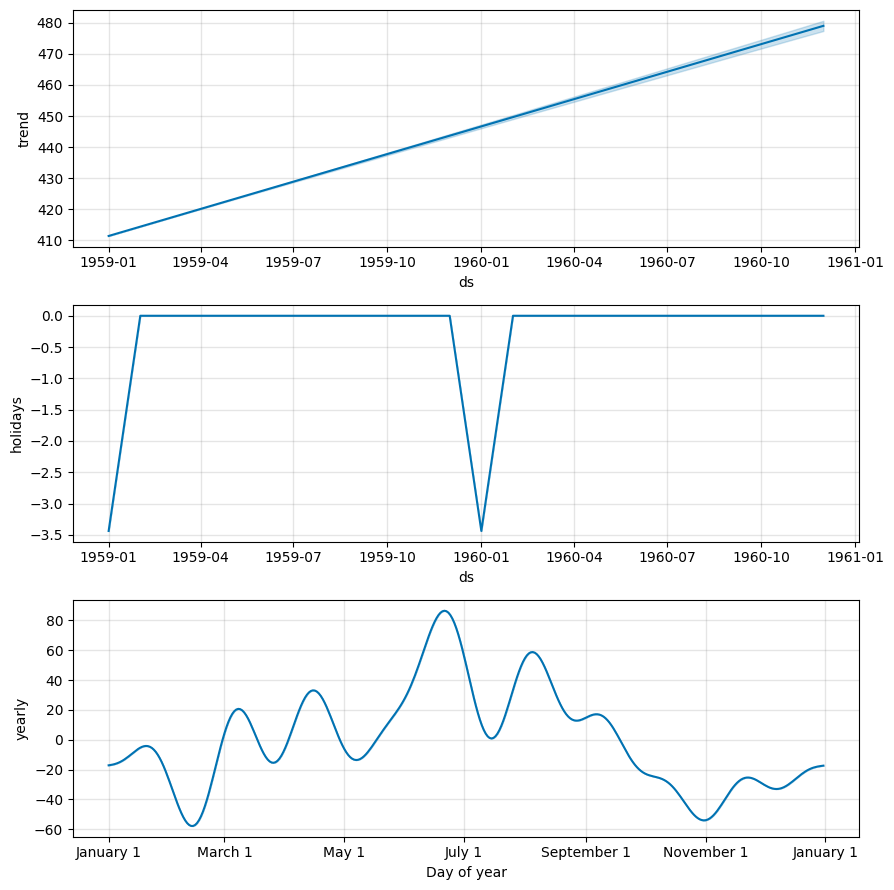

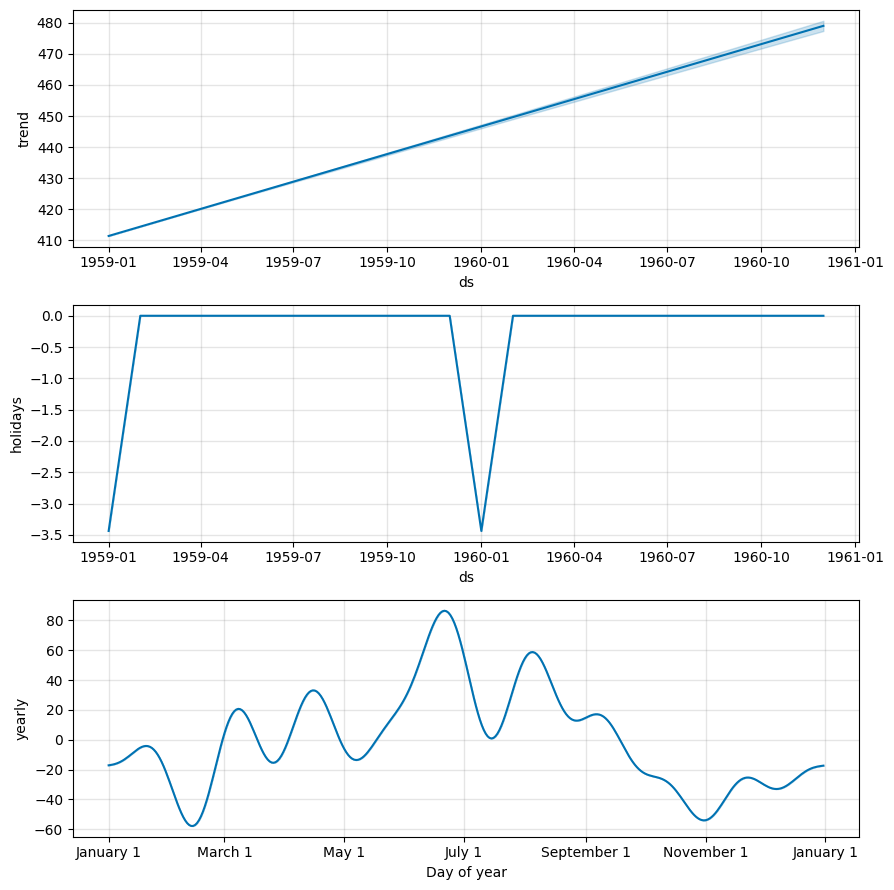

In [16]:
model.plot_components(forecast)

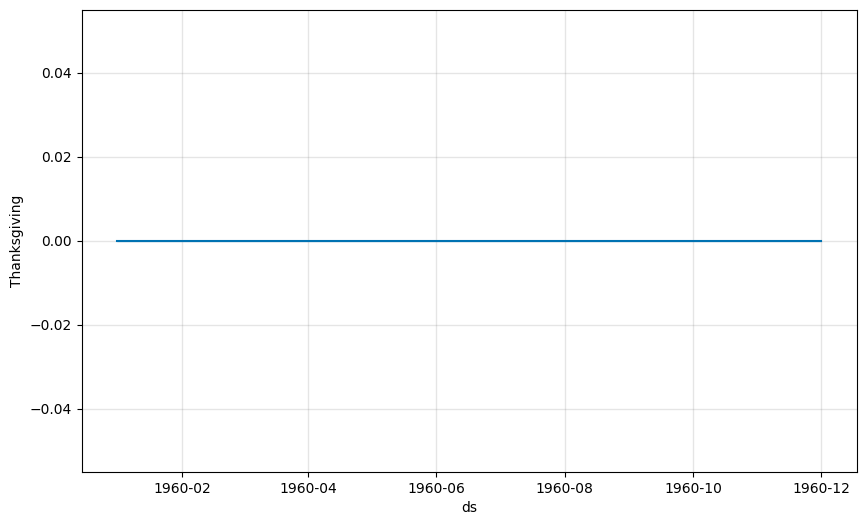

In [17]:
fig = plot_forecast_component(model, forecast, 'Thanksgiving')

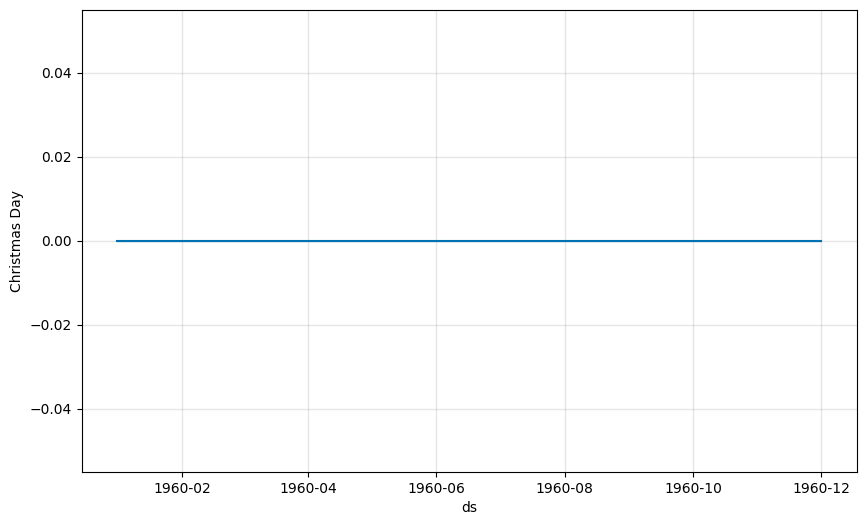

In [18]:
fig = plot_forecast_component(model, forecast, 'Christmas Day')

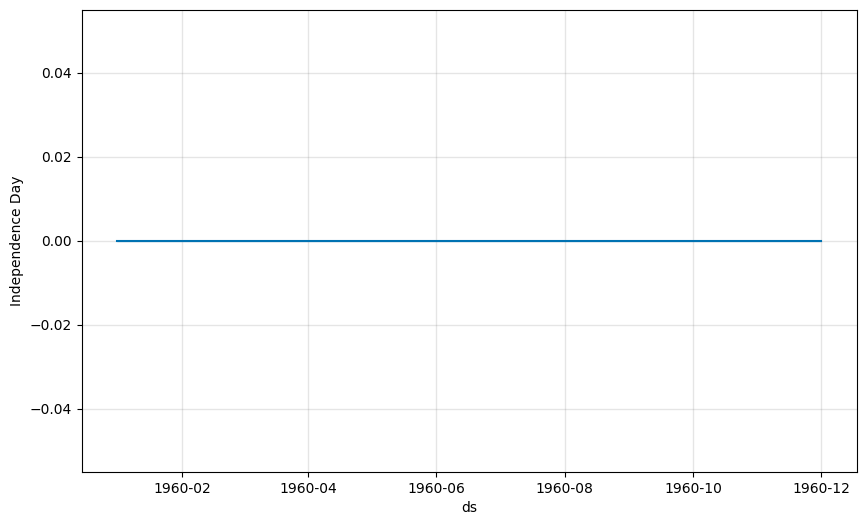

In [19]:
fig = plot_forecast_component(model, forecast, 'Independence Day')

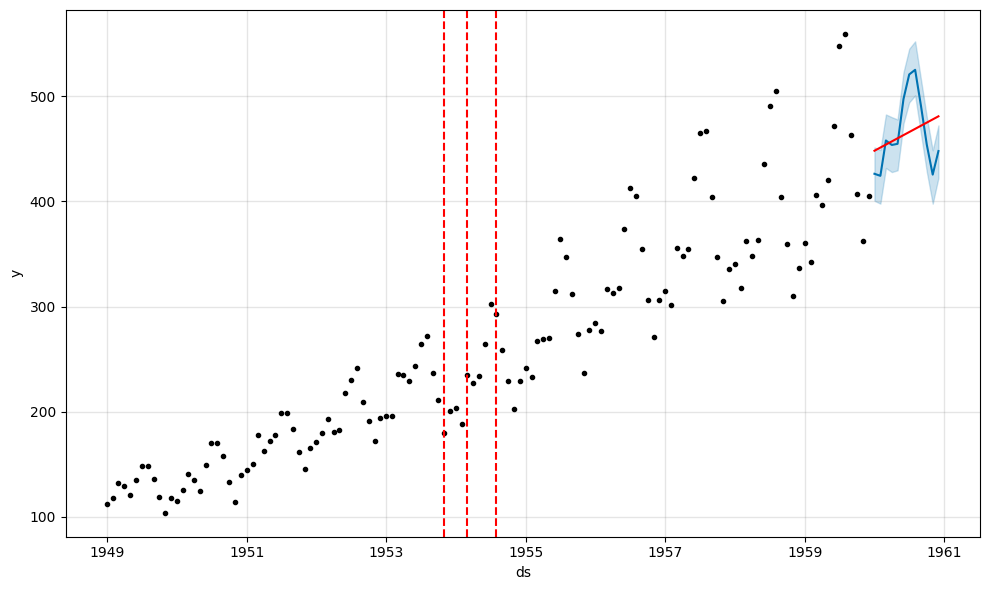

In [20]:
# Change point detection
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [21]:
model.changepoints

4     1949-05-01
8     1949-09-01
12    1950-01-01
17    1950-06-01
21    1950-10-01
25    1951-02-01
29    1951-06-01
33    1951-10-01
37    1952-02-01
42    1952-07-01
46    1952-11-01
50    1953-03-01
54    1953-07-01
58    1953-11-01
62    1954-03-01
67    1954-08-01
71    1954-12-01
75    1955-04-01
79    1955-08-01
83    1955-12-01
87    1956-04-01
92    1956-09-01
96    1957-01-01
100   1957-05-01
104   1957-09-01
Name: ds, dtype: datetime64[ns]

In [22]:
train_df = train_data.copy()
valid_df = valid_data.copy()

In [23]:
valid_df.set_index('ds', inplace=True)
train_df.set_index('ds', inplace=True)

In [24]:
train_df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [25]:
forecast_plot(
    train_df,
    valid_df,
    forecast["yhat"],
    ["Train", "Valid", "Predict"],
    "Prophet",
    "Date",
    "Demand",
)

In [26]:
forecast_plot(train_df, valid_df, forecast['yhat'], ['Train', 'Valid', 'Predict'], 'Prophet') 

TypeError: forecast_plot() missing 2 required positional arguments: 'xaxis_title' and 'yaxis_title'